In [1]:
# Imports
import sys
import os
sys.path.append(os.path.relpath('../../'))
sys.path.append(os.path.relpath('../'))

from helpers import *
import numpy as np
import capytaine as cpt
import logging

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
file1 = "data/proto-cfs.pkl"
file2 = "data/MEEM-sweep.pkl"
labels = ["slow", "average", "fast"]

In [3]:
base_spar_rad = 3
base_float_rad = 10
base_spar_depth = 35
base_float_depth = 3
base_h = 70
base_m0 = 0.1
rho = 1023

big_nmk, nmk_max = 200, 150
nmk_for_true = 1500

spar_rads = [0.5, 3, 6]

In [4]:
def generate_and_store(spar_rad, float_rad, spar_depth, float_depth, h, m0, rho, nmk_max, big_nmk):
  a = [spar_rad, float_rad]
  d = [spar_depth, float_depth]
  big_NMK = 3 * [big_nmk]
  print(h, d, a)

  prob = ConvergenceProblemNeighbors(h, d, a, [1, 0], big_NMK, m0, rho)
  mks = [prob.m_k]

  # result is dict w/ form {m0 : {heaving_region : {"am" : val, "dp" : val, region : {"ams" : [vals], "dps" [vals]}}}}
  result = prob.full_convergence_study(nmk_max, [m0], mks)
  result["h"] = h
  result["d"] = d
  result["a"] = a
  result["m0s"] = [m0]
  return result

def check_fast_convergence(spar_rad, float_rad, spar_depth, float_depth, h, m0s, rho, nmk_max, big_nmk):
  heave_vectors = [[1, 0], [0, 1]]
  a = [spar_rad, float_rad]
  d = [spar_depth, float_depth]
  big_NMK = 3 * [big_nmk]
  max_NMK = 3 * [nmk_max]

  print(h, d, a)

  dict1 = sweep_normal_MEEM(h, d, a, heave_vectors, big_NMK, m0s, rho)
  dict2 = sweep_normal_MEEM(h, d, a, heave_vectors, max_NMK, m0s, rho)
  hydros = ["am", "dp"]

  for m0 in m0s:
    for heave_vector in heave_vectors:
      heaving_region = heave_vector.index(1)
      for hydro in hydros:
        hydro1, hydro2 = dict1[m0][heaving_region][hydro], dict2[m0][heaving_region][hydro]
        converges = ((abs(hydro2-hydro1)/hydro1) < 0.01)
        print(converges, m0, heaving_region, hydro)
  return dict1, dict2

def sweep_normal_MEEM(h, d, a, heave_vectors, NMK, m0s, rho):
  output = {m0 : {} for m0 in m0s}
  prob = ConvergenceProblemNeighbors(h, d, a, heave_vectors[0], NMK, m0s[0], rho)
  base_a_matrix = prob.a_matrix()
  for heave_vector in heave_vectors:
    prob.heaving = heave_vector
    heaving_region = heave_vector.index(1)
    base_b_vector = prob.b_vector()
    for m0 in m0s:
      prob.change_m0(m0)
      a_matrix = prob.a_matrix_from_old(base_a_matrix)
      b_vector = prob.b_vector_from_old(base_b_vector)
      x = prob.get_unknown_coeffs(a_matrix, b_vector)
      am, dp = prob.hydro_coeffs(x, "capytaine")
      output[m0][heaving_region] = {}
      output[m0][heaving_region]["am"] = am
      output[m0][heaving_region]["dp"] = dp
  return output

def populate_with_basic_data(spar_rad, float_rad, spar_depth, float_depth, h, m0s, rho, big_nmk):
  heave_vectors = [[1, 0], [0, 1]]
  a = [spar_rad, float_rad]
  d = [spar_depth, float_depth]
  NMK = 3 * [big_nmk]

  print(h, d, a)

  result = sweep_normal_MEEM(h, d, a, heave_vectors, NMK, m0s, rho)
  result["h"] = h
  result["a"] = a
  result["d"] = d
  result["m0s"] = m0s
  return result

In [5]:
# data = {}
# for i in range(3):
#   data[labels[i]] = populate_with_basic_data(spar_rads[i], base_float_rad, base_spar_depth, base_float_depth, base_h, [base_m0], rho, nmk_for_true)
# update_data_file(data, file1)

In [6]:
def get_convergence_point(region_dict, true_value, hydro):
  hydros = region_dict[hydro + "s"]
  incumbent = len(hydros)
  for nmk in range(len(hydros), 0, -1):
    if abs((hydros[nmk - 1] - true_value)/true_value) <= 0.01:
      incumbent = nmk
    else:
      break
  return incumbent

def solve_normal_MEEM(h, d, a, heave_vectors, NMK, m0, rho):
  output = {}
  prob = ConvergenceProblemNeighbors(h, d, a, heave_vectors[0], NMK, m0, rho)
  a_matrix = prob.a_matrix()
  for heave_vector in heave_vectors:
    prob.heaving = heave_vector
    heaving_region = heave_vector.index(1)
    b_vector = prob.b_vector()
    x = prob.get_unknown_coeffs(a_matrix, b_vector)
    am, dp = prob.hydro_coeffs(x, "capytaine")
    output[heaving_region] = {"am" : am, "dp" : dp}
  return output

def get_MEEM_base_nmk(cf_meem, m0):
  nmk_per_region = []
  sub_cf = cf_meem[m0]
  hydros = ["am", "dp"]
  heaves = [0, 1]
  for region in range(3):
    consideration_lst = []
    for hydro in hydros:
      for heave in heaves:
        true_value = sub_cf[heave][hydro]
        consideration_lst.append(get_convergence_point(sub_cf[heave][region], true_value, hydro))
    nmk_per_region.append(max(consideration_lst))
  return nmk_per_region

In [7]:
# Capytaine helper functions
solver = cpt.BEMSolver() 
logging.getLogger("capytaine").setLevel(logging.ERROR)

def deafen(function, *args, **kwargs):
    real_stdout = sys.stdout
    sys.stdout = open(os.devnull, "w")
    output = function(*args, **kwargs)
    sys.stdout = real_stdout
    return output

def get_points(a, d_in, d_out): # These points define the outline of the body
    pt_lst = [(0, - d_in[0])]
    for i in range(len(a)):
        pt_lst.append((a[i], - d_out[i]))
        if i < (len(a) - 1): # not last body region
            if d_out[i] != d_in[i + 1]: # vertical face exists
                pt_lst.append((a[i], - d_in[i + 1]))
        else: # need vertical face to water surface
            pt_lst.append((a[i], 0))
    return pt_lst

def make_face(p1, p2, f_density, t_density):
    zarr = np.linspace(p1[1], p2[1], f_density + 1)
    rarr = np.linspace(p1[0], p2[0], f_density + 1)
    xyz = np.array([np.array([x/np.sqrt(2),y/np.sqrt(2),z]) for x,y,z in zip(rarr,rarr,zarr)])
    return cpt.AxialSymmetricMesh.from_profile(xyz, nphi = t_density)

def faces_and_heaves(heave_status, p1, p2, f_density, t_density, meshes, mask, panel_ct):
    mesh = make_face(p1, p2, f_density, t_density)
    meshes += mesh
    new_panels = f_density * t_density
    if heave_status:
        direction = [0, 0, 1]
    else:
        direction = [0, 0, 0]
    for i in range(new_panels):
        mask.append(direction)
    return meshes, mask, (panel_ct + new_panels)

def get_excitation_phase(result):
    return np.angle((cpt.assemble_dataset([result]))["excitation_force"][0][0][0])

def make_body(pts, t_densities, f_densities, heaving):
    meshes = cpt.meshes.meshes.Mesh()
    panel_ct = 0
    mask = []
    heave_region = -1
    for i in range(len(pts) - 1):
        p1, p2 = pts[i], pts[i + 1]
        if p1[0] != p2[0]: # face spans some horizontal distance
            heave_region += 1 # advance to next region
            # make a horizontal face
            meshes, mask, panel_ct = faces_and_heaves(heaving[heave_region], p1, p2, f_densities[i], t_densities[heave_region], meshes, mask, panel_ct)
        else: # make a vertical face
            if p1[1] <= p2[1]: # body on inside
                j = heave_region # defer to variables of inner region
            else: # body on outside
                j = heave_region + 1 # defer to variables of outer region
            meshes, mask, panel_ct = faces_and_heaves(heaving[j], p1, p2, f_densities[i], t_densities[j], meshes, mask, panel_ct)
    body = deafen(cpt.FloatingBody, mesh = meshes) # unclosed boundary warnings
    return body, panel_ct, mask

def construct_and_solve(a, d, heaving, t_densities, f_densities, h, m0, rho,
                        show_mesh = False, show_pc = False, show_hydros = False):
    pt_lst = get_points(a, d, d)
    
    body, panel_count, mask = make_body(pt_lst, t_densities, f_densities, heaving)
    body.dofs["Heave"] = mask  
    if show_mesh:
        body.show_matplotlib()
        plt.show()
    
    rad_problem = cpt.RadiationProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    result_r = solver.solve(rad_problem, keep_details = True)

    # diff_problems = [cpt.DiffractionProblem(body = body, wavenumber = m0, water_depth = h, rho = rho) for m0 in m0s]
    # result_ds = solver.solve_all(diff_problems, keep_details = True)

    if show_pc: print("Panel Count: ", panel_count)
    if show_hydros:
        print(result_r.added_mass)
        print(result_r.radiation_damping)
    # if show_phase: print("Excitation Phase: ", self.get_excitation_phase(result_d))
    
    result = {"cpt am" : result_r.added_mass["Heave"],
              "cpt dp" : result_r.radiation_damping["Heave"],
              "Panel Count" : panel_count}

    return result

In [8]:
def generate_area_densities(d, a, inner_density, outer_density):
  # density = panels/(m^2), divs = m/panel
  idiv = np.sqrt(1/inner_density)
  odiv = np.sqrt(1/outer_density)
  t_densities = [max(int((2 * np.pi * a[0] / idiv)) + 1, 4),
                 max(int((2 * np.pi * a[1] / odiv)) + 1, 4)]
  f_densities = [int(a[0]/idiv) + 1,
                 int((d[0] - d[1])/idiv) + 1,
                 int((a[1] - a[0])/odiv) + 1,
                 int(d[1]/odiv) + 1]
  return t_densities, f_densities

def cpt_generate_and_update(cf, inner_density, outer_density, heave, rho = rho):
  h, d, a = cf["h"], cf["d"], cf["a"]

  t_densities, f_densities = generate_area_densities(d, a, inner_density, outer_density)
  for m0 in cf["m0s"]:
    heave_vector = [1 if j == heave else 0 for j in range(2)]
    result = construct_and_solve(a, d, heave_vector, t_densities, f_densities, h, m0, rho,
                                  show_mesh = False, show_pc = False, show_hydros = False)
    cf[m0][heave]["cpt"].append({"inner density" : inner_density, "outer density" : outer_density,
                              "Panel Count" : result["Panel Count"],
                              "am" : result["cpt am"], "dp" : result["cpt dp"]})
      
def meem_generate_and_update(cf_meem, cf_cpt, m0, meem_mults):
  base_MEEM_nmk = get_MEEM_base_nmk(cf_meem, m0)
  h, d, a = cf_meem["h"], cf_meem["d"], cf_meem["a"]
  heave_vectors = [1, 0], [0, 1]
  for mult in meem_mults:
    NMK = [ int(nmk * mult) + 1 for nmk in base_MEEM_nmk]
    results = solve_normal_MEEM(h, d, a, heave_vectors, NMK, m0, rho)
    for heave in range(2):
      results[heave]["mult"] = mult
      results[heave]["NMK"] = NMK
    for i in range(2):
      cf_cpt[m0][i]["MEEM"].append(results[i])

In [9]:
# # Populate capytaine values.
# data = open_pkl_file(file1) 

# for label in labels:
#   cf = data[label]
#   for m0 in cf["m0s"]:
#     for heave in [1]:
#       cf[m0][heave]["cpt"] = []
#       for area_density in [8, 4, 2, 1, 0.5, 0.25, 0.2, 0.15, 0.1, 0.05]:
#         cpt_generate_and_update(cf, area_density, area_density, heave)
#         print(f"Finished density {area_density}")
#   update_data_file(data, file1)
#   print("Finished a variant.")

In [10]:
# meem_data = open_pkl_file(file2)
# meem_average, meem_fast = meem_data[1][5], meem_data[0][9]
# meem_slow = generate_and_store(spar_rads[0], base_float_rad, base_spar_depth, base_float_depth,
#                                base_h, base_m0, rho, nmk_max, big_nmk)
# meem_convergence_sets = [meem_slow, meem_average, meem_fast]

In [11]:
# meem_mults = list(np.linspace(0.1, 3, 30)) + list(np.linspace(3.5, 8, 10))

# for i in range(3):
#   cf_cpt, cf_meem = data[labels[i]], meem_convergence_sets[i]
#   for m0 in cf_cpt["m0s"]:
#     for heave in [0, 1]:
#       cf_cpt[m0][heave]["MEEM"] = []
#     meem_generate_and_update(cf_meem, cf_cpt, m0, meem_mults)
#     print(f"Finished an m0.")
#   update_data_file(data, file1)
#   print("Finished a variant.")

In [12]:
# file 2 & 3 helper functions
def get_nmks(meem_lst):
  output = []
  for entry in meem_lst:
    nmk = entry["NMK"]
    nmk_total = nmk[0] + 2 * nmk[1] + nmk[2]
    output.append(nmk_total)
  return output

def get_panel_counts(cpt_lst):
  return [cpt_entry["Panel Count"] for cpt_entry in cpt_lst]

# Extrapolate computation times:
def meem_computation_time(NMK):
  unknown_coeffs = NMK[0] + 2 * sum(NMK[1:-1]) + NMK[-1]
  t1 = 8.3e-5 * NMK[-1] # mk
  t2 = 3.9e-6 * sum([NMK[i] * NMK[i+1] for i in range(len(NMK) - 1)]) # coupling
  t3 = 4.8e-5 * unknown_coeffs # bessels
  t4 = 5.5e-8 * (unknown_coeffs)**2 # a matrix population
  t5 = 8.1e-6 * unknown_coeffs # b vector population
  t6 = 5.5e-10 * (unknown_coeffs)**3 # b vector solve
  return sum([t1, t2, t3, t4, t5, t6])

def cpt_computation_time(panel_count):
  t1 = 1.2e-4 * panel_count
  t2 = 1.5e-6 * panel_count
  t3 = 2.4e-6 * panel_count**2
  t4 = 3.5e-7 * panel_count
  t5 = 2.5e-9 * panel_count**2
  return sum([t1, t2, t3, t4, t5])

def get_meem_times(meem_lst):
  output = []
  for entry in meem_lst:
    nmk = entry["NMK"]
    output.append(meem_computation_time(nmk))
  return output

def get_cpt_times(cpt_lst):
  return [cpt_computation_time(cpt_entry["Panel Count"]) for cpt_entry in cpt_lst]

def get_fraction_off_vals(lst, hydro, true_val):
  output = []
  for entry in lst:
    val = entry[hydro]
    output.append((val - true_val)/true_val)
  return output

def get_plottable_info(cf, m0):
  am1, dp1 = cf[m0][1]["am"], cf[m0][1]["dp"]

  return {"NMKs" : get_nmks(cf[m0][1]["MEEM"]),
          "MEEM times" : get_meem_times(cf[m0][1]["MEEM"]),
          "MEEM 1 am" : get_fraction_off_vals(cf[m0][1]["MEEM"], "am", am1),
          "MEEM 1 dp" : get_fraction_off_vals(cf[m0][1]["MEEM"], "dp", dp1),
          "Panel Counts" : get_panel_counts(cf[m0][1]["cpt"]),
          "CPT times" : get_cpt_times(cf[m0][1]["cpt"]),
          "CPT 1 am" : get_fraction_off_vals(cf[m0][1]["cpt"], "am", am1),
          "CPT 1 dp" : get_fraction_off_vals(cf[m0][1]["cpt"], "dp", dp1)}

def trunc_to_matrix_size(trunc, size_lst, data_lst, vtrunc, logs):
  if vtrunc == None:
    vtrunc = max([abs(val) for val in data_lst])
  xs, ys = [], []
  for i in range(len(size_lst)):
    if size_lst[i] < trunc and abs(data_lst[i]) < vtrunc:
      xs.append(size_lst[i])
      if logs:
        ys.append(np.log10(abs(data_lst[i])))
      else:
        ys.append(data_lst[i])
  return xs, ys

def plot_both_against_fraction(data, trunc, labels, vtrunc = None, logs = False):
  colors = ["red", "orange", "green", "blue"]
  meem_xs = data["NMKs"]
  cpt_xs = data["Panel Counts"]
  # plt.hlines(0, color = "black", xmin = 0, xmax = trunc)
  if logs:
    plt.hlines(np.log10(0.01), xmin = 0, xmax = trunc, color = "black", linestyle = ":", label = "1% convergence")
  for i in range(len(labels)):
    meem_label = "MEEM" + labels[i]
    cpt_label = "CPT" + labels[i]
    xs, ys = trunc_to_matrix_size(trunc, meem_xs, data[meem_label], vtrunc, logs)
    plt.plot(xs, ys, color = colors[i], label = meem_label, linestyle = "-")
    xs, ys = trunc_to_matrix_size(trunc, cpt_xs, data[cpt_label], vtrunc, logs)
    plt.plot(xs, ys, color = colors[i], label = cpt_label, linestyle = "--")
  plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1)) 
  plt.grid()
  plt.xlabel("Side length of matrix")
  ylab = "Fraction off from true value" if not logs else "Log of fraction off of true value"
  plt.ylabel(ylab)
  plt.title("Convergence wrt matrix size for RM3 in MEEM, Capytaine")
  plt.show()

def log_to_percent(y, _):
    # y is the log10 value; convert back, multiply by 100, format as %
    val = 10**y * 100
    if val > 1:
      output = f"{val:.0f}%"
    else:
      output = f"{val:.1g}%"
    return output

def reg_to_percent(y, _):
    # y is the log10 value; convert back, multiply by 100, format as %
    val = y * 100
    if abs(val) > 1:
      output = f"{val:.0f}%"
    else:
      output = f"{val:.1g}%"
    return output

def plot_both_against_fraction_times(data, trunc, labels, vtrunc = None, logs = False):
  colors = ["red", "orange", "green", "blue"]
  meem_xs = data["MEEM times"]
  cpt_xs = data["CPT times"]
  # plt.hlines(0, color = "black", xmin = 0, xmax = trunc)
  # if logs:
  #   plt.hlines(np.log10(0.01), xmin = 0, xmax = trunc, color = "black", linestyle = ":", label = "1% convergence")
  for i in range(len(labels)):
    meem_label = "MEEM" + labels[i]
    cpt_label = "CPT" + labels[i]
    xs, ys = trunc_to_matrix_size(trunc, meem_xs, data[meem_label], vtrunc, logs)
    plt.plot(xs, ys, color = colors[i], label = meem_label, linestyle = "-")
    xs, ys = trunc_to_matrix_size(trunc, cpt_xs, data[cpt_label], vtrunc, logs)
    plt.plot(xs, ys, color = colors[i], label = cpt_label, linestyle = "--")
  plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1)) 
  plt.grid()
  if logs:
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(log_to_percent))
  else:
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(reg_to_percent))
  plt.xlabel("Estimated computation time (s)")
  ylab = "Percent off of true value"
  plt.ylabel(ylab)
  plt.title("Convergence wrt matrix size for RM3 in MEEM, Capytaine")
  plt.show()

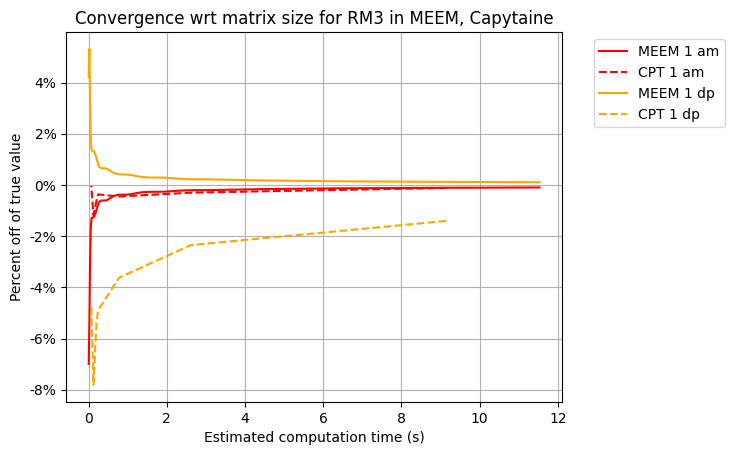

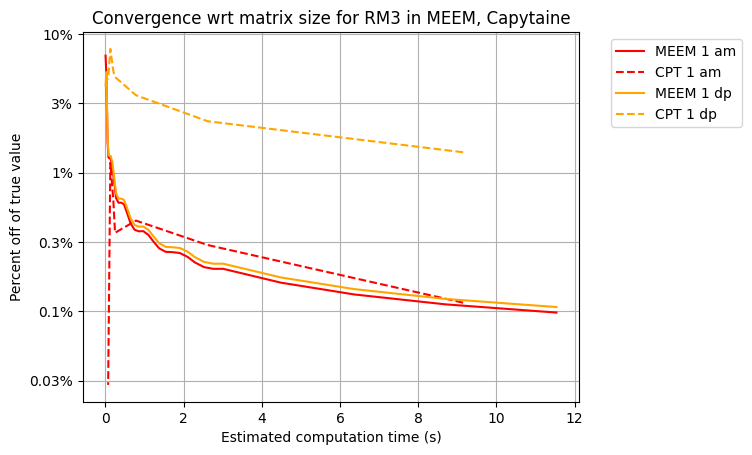

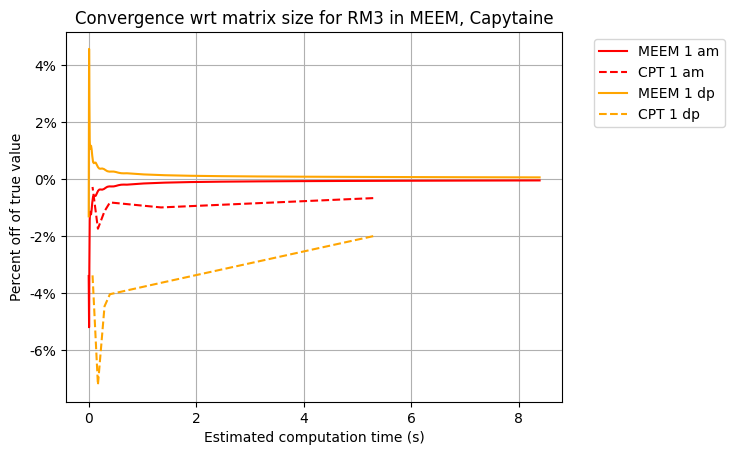

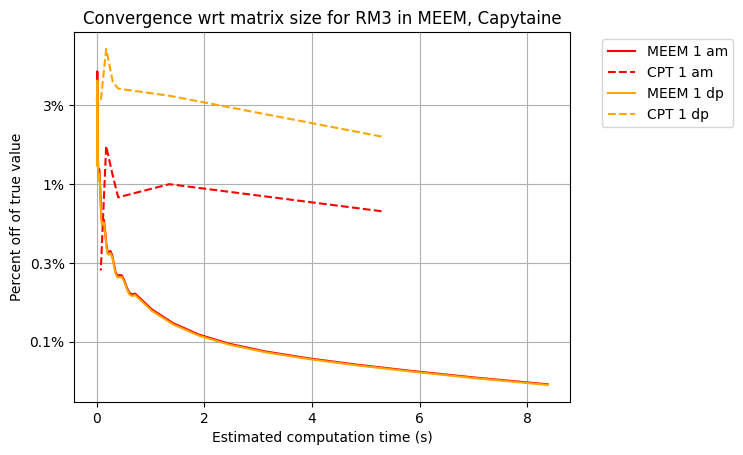

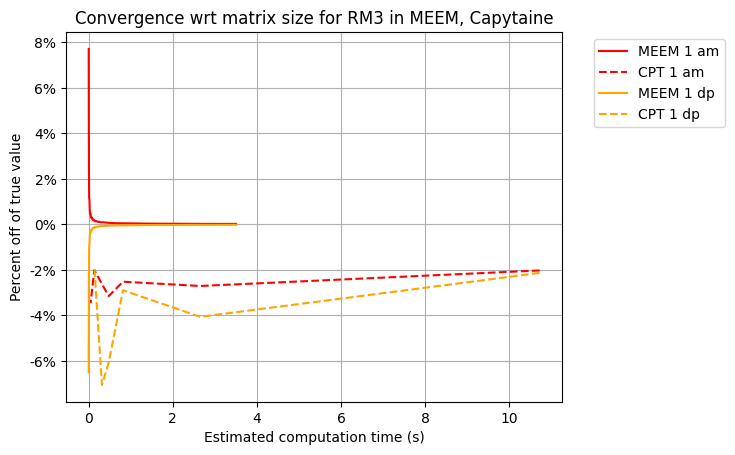

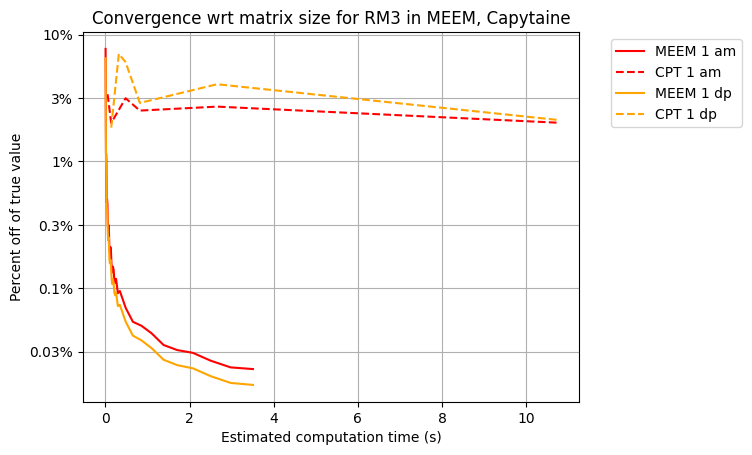

In [13]:
data = open_pkl_file(file1)
for cf in list(data.values()):
  m0 = cf["m0s"][0]
  plottable_data = get_plottable_info(cf, m0)
  plot_labels = [" 1 am", " 1 dp"]
  plot_both_against_fraction_times(plottable_data, 12, plot_labels, vtrunc = None, logs = False)
  plot_both_against_fraction_times(plottable_data, 12, plot_labels, vtrunc = None, logs = True)